# Import Libs

In [1]:
import tensorflow as tf ### models
import matplotlib.pylab as plt ### ploting
import seaborn as sns
import numpy as np ### math computations
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Conv2D, MaxPooling2D, Flatten, InputLayer, BatchNormalization, Input, Layer,Dropout,
                                     RandomFlip, RandomRotation, Resizing, Rescaling #for augmentation
                                     )
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, TruePositives, FalsePositives, FalseNegatives, TrueNegatives,Precision,Recall, AUC
from sklearn.metrics import confusion_matrix, roc_curve,f1_score

from tensorflow.keras.regularizers import L1,L2
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau

In [2]:
tf.__version__

'2.14.0'

# Load Malaria Dataset

In [3]:
dataset, dataset_info = tfds.load('malaria',with_info=True, as_supervised=True, shuffle_files = True, split = 'train')

In [4]:
tfds.__version__

'4.9.3'

# Data Split

In [5]:
TRANI_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [6]:
def splits(dataset, TRANI_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRANI_RATIO*DATASET_SIZE))
    val_test__dataset = dataset.skip(int(TRANI_RATIO*DATASET_SIZE))
    val_dataset = val_test__dataset.take(int(VAL_RATIO*DATASET_SIZE))
    test_dataset = val_test__dataset.skip(int(VAL_RATIO*DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset


In [7]:
#dataset = tf.data.Dataset.range(20)
train_dataset, val_dataset, test_dataset = splits(dataset, TRANI_RATIO, VAL_RATIO, TEST_RATIO)

# Data Visualizing

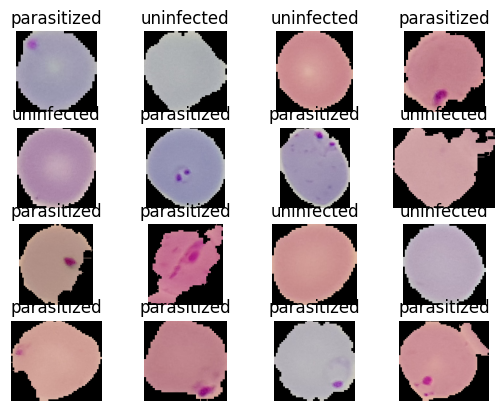

In [8]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

In [9]:
 dataset_info.features['label'].int2str(0)

'parasitized'

# Data Preprocessing

In [10]:
IM_SIZE = 224
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0,label

## tf.image augment

In [11]:
## tf.image augment
def augment(image, label):
    image, label = resize_rescale(image, label)
    image = tf.image.rot90(image)
    image = tf.image.flip_left_right(image)
    return image, label

# tf.keras.layers

In [12]:
resizing_rescaling_layers = tf.keras.Sequential([
    Resizing(IM_SIZE,IM_SIZE),
    Rescaling(1.0/255)
])

In [13]:
## tf.keras.layers augment
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (0.25, 0.2501),),
    RandomFlip(mode='horizontal', )
])

def augment_layer(image, label):
  return augment_layers(resizing_rescaling_layers(image), training = True), label

In [14]:
BATCH_SIZE = 32
train_dataset = (train_dataset
                 .shuffle(buffer_size= 8 , reshuffle_each_iteration= True)
                 #.map(augment_layer) # augment_layers instead of augment
                 .batch(1)
                 .prefetch(tf.data.AUTOTUNE))
val_dataset = (val_dataset
               .shuffle(buffer_size= 8 , reshuffle_each_iteration= True)
                # .map(augment_layer) # augment_layers instead of augment
               .batch(1)
               .prefetch(tf.data.AUTOTUNE))

#test_dataset = test_dataset.map(resizing_rescaling_layers)

# Model Subclassing

In [15]:
class FeatureExtractor(Layer):
    def __init__(self, num_filters, kernel_size,num_strides, padding, activation_function, pool_size, droupout_rate, regularizer_rate):
        super(FeatureExtractor, self).__init__()
        self.conv_1 = Conv2D(filters= num_filters,kernel_size=kernel_size, strides=num_strides, padding= padding, activation = activation_function, kernel_regularizer = L2(regularizer_rate))
        self.batch_1 = BatchNormalization()
        self.droupout1 = Dropout(rate = droupout_rate)
        self.pool_1 = MaxPooling2D(pool_size=pool_size, strides=num_strides)

        self.conv_2 = Conv2D(filters= 2*num_filters,kernel_size=kernel_size, strides=num_strides, padding= padding, activation = activation_function, kernel_regularizer = L2(regularizer_rate))
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPooling2D(pool_size=pool_size, strides=2*num_strides)

    def call(self, x, training):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.droupout1(x)
        x = self.pool_1(x)


        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.pool_2(x)

        return x

In [16]:
feature_sub_classed = FeatureExtractor(num_filters = 8, kernel_size = 3,num_strides = 1, padding= "valid", activation_function = "relu", pool_size = (2,2), droupout_rate = 0.3, regularizer_rate = 0.01)

In [17]:
class LenetModel(Model):
    def __init__(self, num_filters, kernel_size,num_strides, padding, activation_function, pool_size, output_activation,droupout_rate, regularizer_rate):
        super(LenetModel, self).__init__()

        self.featureExtractor = FeatureExtractor(
                                    num_filters = num_filters,
                                    kernel_size = kernel_size,
                                    num_strides = num_strides,
                                    padding = padding,
                                    activation_function = activation_function,
                                    pool_size = pool_size,
                                    droupout_rate = droupout_rate,
                                    regularizer_rate = regularizer_rate)
        self.flatten = Flatten()

        self.dense_1 = Dense(units = 100, activation=activation_function, kernel_regularizer = L2(regularizer_rate))
        self.batch_1 = BatchNormalization()
        self.droupout1 = Dropout(rate = droupout_rate)
        self.dense_2 = Dense(units = 10, activation=activation_function, kernel_regularizer = L2(regularizer_rate))
        self.batch_2 = BatchNormalization()

        self.dense_3 = Dense(units=1, activation = output_activation)

    def call(self, x, training):
        x = resizing_rescaling_layers(x)
        x = augment_layers(x)

        x = self.featureExtractor(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.batch_1(x)
        x = self.droupout1(x)

        x = self.dense_2(x)
        x = self.batch_2(x)

        x = self.dense_3(x)

        return x

In [18]:
lenet_model = LenetModel(num_filters = 8, kernel_size = 3,num_strides = 1, padding= "valid", activation_function = "relu", pool_size = (2,2),
                         output_activation = "sigmoid", droupout_rate = 0.3, regularizer_rate=0.01)
lenet_model(Input(shape= (None, None,3)))
lenet_model.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  19009700  
                                                                 
 batch_normalization_4 (Bat  multiple                  400       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  

# Optimizers

In [19]:
metrics = [TruePositives(name='tp'), FalsePositives(name= 'fp'), FalseNegatives(name= 'fn'), TrueNegatives(name='tn'),
          BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [20]:
lenet_model.compile(optimizer=Adam(learning_rate=0.1), loss=BinaryCrossentropy(), metrics= metrics,)# run_eagerly=True)

# Callbacks

In [21]:
class LossCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        print("\n For Epoch Number {} the model has a loss of {} ".format(epoch+1, logs["loss"]))

    def no_batch_end(self, batch, logs):
        print("\n For Batch Number {} the model has a loss of {} ".format(batch+1, logs))

## CSVLogger

In [22]:
csv_callback = CSVLogger( 'logs.csv', separator = ',', append = False)

## EarlyStopping

In [23]:
es_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
)

## LearningRateScheduler

In [24]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [25]:
callbacks_scheduler = LearningRateScheduler(scheduler, verbose=1)

# ModelCheckpointing

In [26]:
checkpoints_callbacks = ModelCheckpoint(
    'checkpoints/', monitor = 'val_loss', verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto',
    save_freq='epoch'
)

# ReduceLROnPlateau

In [27]:
plateau_callbacks = ReduceLROnPlateau(monitor='val_loss', factor=0.2,verbose=1,
                              patience=5, min_lr=0.001)

# Train

In [28]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs = 10 , verbose=1, )# callbacks = [csv_callback, plateau_callbacks])

Epoch 1/10
22046/22046 [==============================] - 390s 17ms/step - loss: 2.3290 - tp: 5627.0000 - fp: 5622.0000 - fn: 5400.0000 - tn: 5397.0000 - accuracy: 0.5000 - precision: 0.5002 - recall: 0.5103 - auc: 0.5011 - val_loss: 2.1600 - val_tp: 1392.0000 - val_fp: 1363.0000 - val_fn: 0.0000e+00 - val_tn: 0.0000e+00 - val_accuracy: 0.5053 - val_precision: 0.5053 - val_recall: 1.0000 - val_auc: 0.4770
Epoch 2/10
22046/22046 [==============================] - 361s 16ms/step - loss: 2.1022 - tp: 5550.0000 - fp: 5428.0000 - fn: 5475.0000 - tn: 5593.0000 - accuracy: 0.5054 - precision: 0.5056 - recall: 0.5034 - auc: 0.5081 - val_loss: 2.0664 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_fn: 1396.0000 - val_tn: 1359.0000 - val_accuracy: 0.4933 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 3/10
22046/22046 [==============================] - 364s 16ms/step - loss: 2.1067 - tp: 5663.0000 - fp: 5701.0000 - fn: 5362.0000 - tn: 5320.0000 - accuracy: 0.4982 - p

# Loss

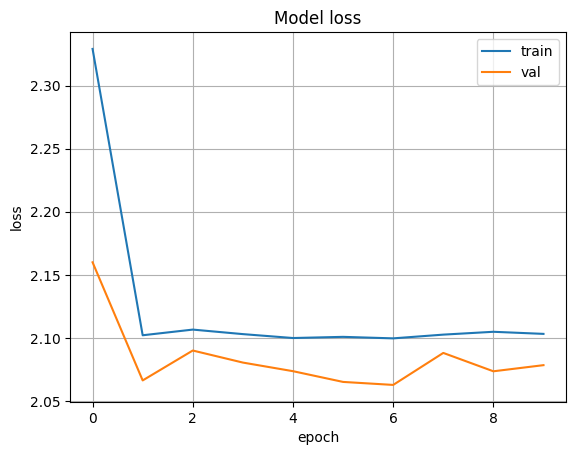

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'])
plt.grid(True)
plt.show()

# Performance

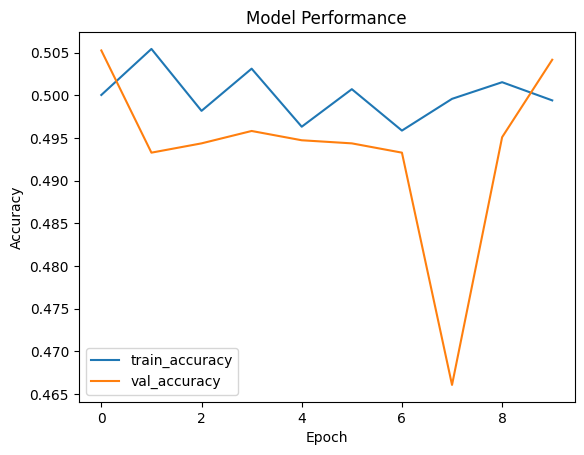

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Performance')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model Evaluation and Testing

In [31]:
test_dataset2 = test_dataset.batch(1)

In [32]:
evals = lenet_model.evaluate(test_dataset2, return_dict = True)
evals

2757/2757 [==============================] - 23s 5ms/step - loss: 2.0816 - tp: 1361.0000 - fp: 1396.0000 - fn: 0.0000e+00 - tn: 0.0000e+00 - accuracy: 0.4937 - precision: 0.4937 - recall: 1.0000 - auc: 0.4822


{'loss': 2.0816171169281006,
 'tp': 1361.0,
 'fp': 1396.0,
 'fn': 0.0,
 'tn': 0.0,
 'accuracy': 0.4936525225639343,
 'precision': 0.4936525225639343,
 'recall': 1.0,
 'auc': 0.4821770191192627}

# Predict

In [33]:
lenet_model.predict(test_dataset2.take(1))[0][0]

1/1 [==============================] - 11s 11s/step


0.57120925

In [34]:
def parasite_or_not(x):
    if x<0.5:
        return str('P')
    else:
        return str('U')

In [35]:
parasite_or_not(lenet_model.predict(test_dataset2.take(1))[0][0])

1/1 [==============================] - 11s 11s/step


'U'

1/1 [==============================] - 0s 21ms/step


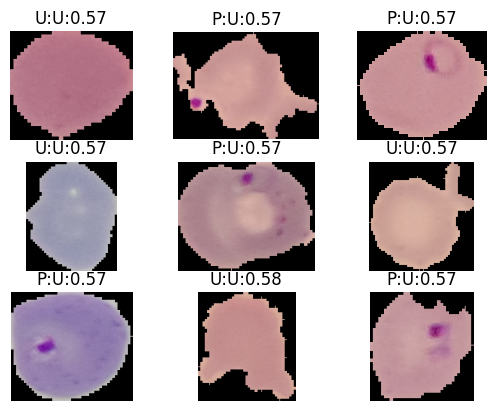

In [36]:
for i, (image, label) in enumerate(test_dataset2.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  res = lenet_model.predict(image)[0][0]
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(res)) + ":"+ str(round(res, 2)))
  plt.axis('off')

In [37]:
test_dataset2.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Visualising Confusion Matrix

In [38]:
inps = []
labels = []
for _,(x,y) in enumerate(test_dataset2):
    labels.append(y)
    inps.append(x)

In [39]:
labels[:5]

[<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>]

In [40]:
labels = np.array([i.numpy()[0] for i in labels])
print(labels)

[1 1 0 ... 0 1 1]


In [41]:
np.array(inps[0]).shape

(1, 118, 133, 3)

In [42]:
predicted = [lenet_model.predict(i) for i in inps ] #np.array(inps)[:,0,...])
len(predicted)

1/1 [==============================] - 0s 18ms/step


2757

In [43]:
pred_labels = np.squeeze(predicted)
pred_labels.shape

(2757,)

In [44]:
threshold = 0.5

cm = confusion_matrix(labels, pred_labels > threshold)
print(cm)

[[   0 1390]
 [   0 1367]]


Text(0.5, 58.7222222222222, 'Predicted')

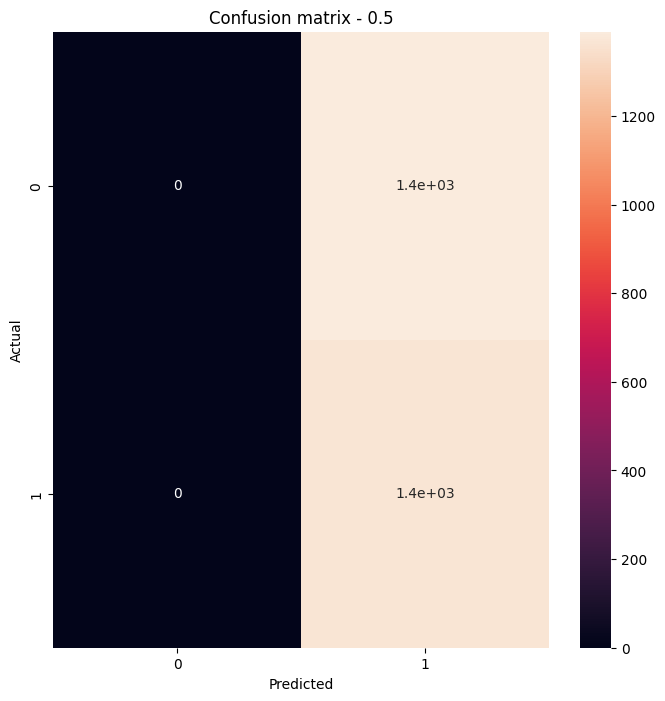

In [45]:
plt.figure(figsize = (8, 8))
sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

# ROC Plots

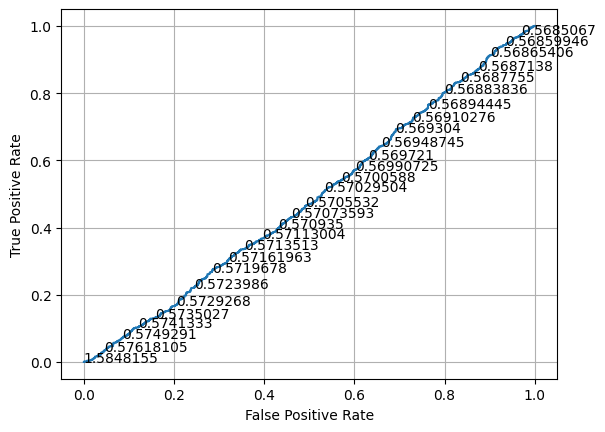

In [46]:
fp, tp ,threshoulds = roc_curve(labels, pred_labels)
plt.plot(fp, tp)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.grid()

skip = 50

for i in range(0, len(threshoulds), skip):
    plt.text(fp[i], tp[i], threshoulds[i])
plt.show()

In [47]:
f1 = f1_score(y_true= labels, y_pred= np.round(pred_labels))
f1

0.6629485935984482